In [1]:
import torch, os
import torchvision.transforms as T
from PIL import Image
from tqdm import tqdm
from diffusers import AutoencoderDC
from utils import (
    latent_to_PIL, 
    make_grid, 
    dcae_scalingf, 
    PIL_to_latent,
    pil_add_text,
)

/home/g/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.mps.is_available() else "cpu"
dtype = torch.bfloat16

## DC-AE 
* dtype does not make a difference if bfloat16 or float32 (not shown)

In [3]:
inputs_path = "./images"
output_path = "./output"

dcae_repos = [
    "mit-han-lab/dc-ae-f32c32-sana-1.0-diffusers",
    "mit-han-lab/dc-ae-f32c32-sana-1.1-diffusers",
]

In [4]:
def resize(img):    
    transform = T.Compose([
        T.Resize(512, antialias=True),
        T.CenterCrop(512),
    ])
    return transform(img)

In [5]:
if not os.path.exists(output_path): os.makedirs(output_path)

for dcae_repo in dcae_repos:
    dcae = AutoencoderDC.from_pretrained(dcae_repo, torch_dtype=dtype).to(device)
    dcae_name = dcae_repo.split("/")[1].replace(".","_")
        
    for img_fn in tqdm(os.listdir(inputs_path), f"{dcae_name}"):
        if img_fn.startswith("."): continue
        image = resize(Image.open(f"{inputs_path}/{img_fn}"))
        latent = PIL_to_latent(image, dcae)
        compression_f = (image.size[0]*image.size[1]*3 )// len(latent.flatten()) # tot numbers per img / tot numbers per latent
        image_roundtrip = latent_to_PIL(latent, dcae)
        image_roundtrip = pil_add_text(image_roundtrip, dcae_name, font_size=30, position=(1,1))
        image_roundtrip = pil_add_text(image_roundtrip, f"{compression_f}x", font_size=30, position=(1,30))
        
        image_roundtrip.save(f"{output_path}/{img_fn.split('.')[0]}_{dcae_name}.png")

dc-ae-f32c32-sana-1_1-diffusers: 100%|██████████| 13/13 [00:01<00:00,  6.62it/s]


## `KBlueLeaf/EQ-SDXL-VAE`
* https://huggingface.co/KBlueLeaf/EQ-SDXL-VAE
* https://arxiv.org/abs/2502.09509

> The core innovation of the paper is the introduction of EQ-VAE, a method that regularizes the latent space of autoencoders to enforce spatial equivariance. Standard autoencoders for generative image models do not guarantee that basic spatial transformations—like scaling or rotation—are reflected consistently in their latent representations. EQ-VAE addresses this by adding a regularization term to the training objective so that transforming the latent code (by a spatial transformation) closely matches the encoding of the transformed image. This implicit regularization:
> * Makes the latent space smoother and simpler (lower intrinsic dimensionality),
> * Improves the performance of downstream generative models (e.g., diffusion models, masked generative models), and
> *  Accelerates training (in some cases achieving up to a 7× speed-up).
>  
> Importantly, EQ-VAE is versatile as it can be applied to both continuous and discrete autoencoders without needing architectural changes or retraining from scratch—it only requires fine-tuning pre-trained models.

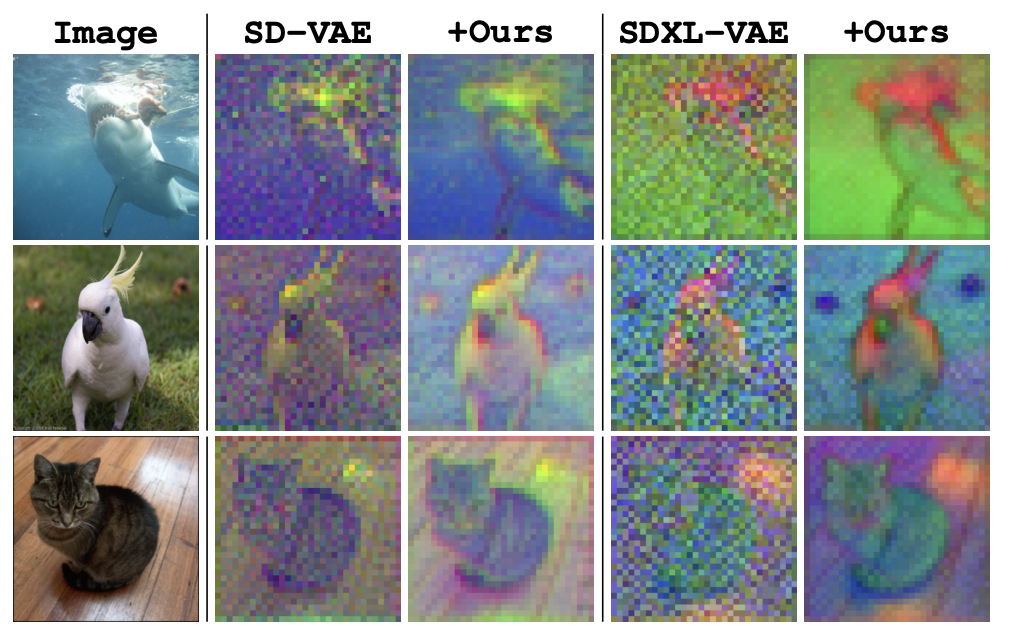

In [6]:
from diffusers import AutoencoderKL

vae_repo = "KBlueLeaf/EQ-SDXL-VAE"
vae = AutoencoderKL.from_pretrained(vae_repo).to(dtype).to(device)

In [7]:
# source: https://wandb.ai/capecape/ddpm_clouds/reports/Using-Stable-Diffusion-VAE-to-encode-satellite-images--VmlldzozNDA2OTgx
def kl_encode(img, vae):
    img_tensor = T.transforms.ToTensor()(img)[None].to(dtype).to(device)
    img_tensor = img_tensor * 2 - 1
    with torch.no_grad():
        latent = vae.encode(img_tensor).latent_dist.sample() * vae.config.scaling_factor
    return latent

def kl_decode(latent, vae):
    with torch.no_grad():
        img = vae.decode(latent / vae.config.scaling_factor).sample.squeeze().cpu()
    img = (img * 0.5 + 0.5).clamp(0, 1)
    img = T.ToPILImage()(img.float())
    return img

In [8]:
vae_name = vae_repo.split("/")[1].replace(".","_")

for img_fn in tqdm(os.listdir(inputs_path), f"{vae_name}"):
    if img_fn.startswith("."): continue
    image = resize(Image.open(f"{inputs_path}/{img_fn}"))
    latent = kl_encode(image, vae)
    compression_f = (image.size[0]*image.size[1]*3 )// len(latent.flatten()) # tot numbers per img / tot numbers per latent

    image_roundtrip = kl_decode(latent, vae)
    image_roundtrip = pil_add_text(image_roundtrip, vae_name, font_size=30, position=(1,1))
    image_roundtrip = pil_add_text(image_roundtrip, f"{compression_f}x", font_size=30, position=(1,30))
    
    image_roundtrip.save(f"{output_path}/{img_fn.split('.')[0]}_{vae_name}.png")

EQ-SDXL-VAE: 100%|██████████████████████████████| 13/13 [00:01<00:00,  6.81it/s]


## Create a gallery with orig, vae1, vae2, etc

In [9]:
gallery_path = "./output_gallery"
ae_repos = [
    "KBlueLeaf/EQ-SDXL-VAE",
    "mit-han-lab/dc-ae-f32c32-sana-1.0-diffusers",
    "mit-han-lab/dc-ae-f32c32-sana-1.1-diffusers",
]
if not os.path.exists(gallery_path): os.makedirs(gallery_path)

for img_fn in tqdm(os.listdir(inputs_path)):
    if img_fn.startswith("."): continue
    image = resize(Image.open(f"{inputs_path}/{img_fn}"))
    img_fn = img_fn.split('.')[0]
    ae_names = [ ae_repo.split("/")[1].replace(".","_") for ae_repo in ae_repos]
    ae_images = [ Image.open(f"{output_path}/{img_fn}_{ae_name}.png") for ae_name in ae_names ] 
    make_grid([image] + ae_images, 1).save(f"{gallery_path}/{img_fn}.png")


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.39it/s]
